<a href="https://colab.research.google.com/github/Cclavijo97/FoodVision_101-AI/blob/main/FoodVision_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7c801d6f-ccab-0d3a-046d-2e30a3ef071e)


In [3]:
#Get pre-made helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-05-09 08:36:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-09 08:36:30 (115 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [6]:
dataset_list=tfds.list_builders()
dataset_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [7]:
#Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

In [8]:
#Find: Class names, shape, datatype, labels form(one-hot encoded or not)
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
class_names=ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [10]:
#Review the training data
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
train_data.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image, label in train_data.take(1):
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class (tensor): {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class (tensor): 56
  Class name: huevos_rancheros
  


In [13]:
#After 3 iterations, I saw that the shape changed, thus we have to set one
#The datatype has to be changed to float32 given that uint8 is not processed by neural networks
#Labels are not one-hot encoded, we need to use sparse categorical cross entropy as it works best for these.

In [14]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [15]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

In [16]:
#The information is not normalized.
# we could write a function to change this but since we are using EfficientNetB0, there is no need for this

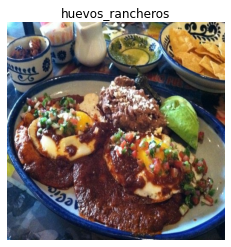

In [17]:
#Iterate through several images and their label to check if they are properly labeled
import matplotlib.pyplot as plt
for image, label in train_data.take(1):
  plt.imshow(image)
  plt.title(class_names[label.numpy()])
  plt.axis(False);

In [18]:
#Everything looks fine.
# let's begin preprocessing.
#Change the image size and the type

def size_type (image, label, img_shape=224):
  """
  Insert image, arrange size to be [img_shape, img_shape]
  and change datatype to float32.
  
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label


In [19]:
#Check if it works
preprocess=size_type(image, label)[0]
print(f"Shape before preprocessing: {image.shape} \nDatatype before preprocessing: {image.dtype}")
print(f"Shape after: {preprocess.shape} \nDatatype after: {preprocess.dtype}")

Shape before preprocessing: (512, 512, 3) 
Datatype before preprocessing: <dtype: 'uint8'>
Shape after: (224, 224, 3) 
Datatype after: <dtype: 'float32'>


In [20]:
#Works, let's prepare our pipelines

#Pass the function to the whole training data
train_data = train_data.map(map_func=size_type, num_parallel_calls=tf.data.AUTOTUNE)

#Shuffle train data and turn it into batches, pass the prefetch so it loads faste
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size = tf.data.AUTOTUNE)

#Map the function to the test data also
test_data = test_data.map(map_func=size_type, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
#Check the data
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [22]:
#Shape and type works
#We'll create some callbacks to save and compare later

checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [23]:
#It would be smart to use mixed precision to check time.
#We'll check if the GPU given by Google Colab fits to the standard required
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7c801d6f-ccab-0d3a-046d-2e30a3ef071e)


In [24]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


<Policy "mixed_float16">

In [25]:
#Let's proceed to create the model

from tensorflow.keras import layers

#Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create inputs
inputs = layers.Input(shape=input_shape, dtype=tf.float16)

#Create x layers
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [27]:
history_food_101_feature=model.fit(train_data,
                                   epochs=3,
                                   steps_per_epoch=len(train_data),
                                   validation_data=test_data,
                                   validation_steps=int(0.15*len(test_data)),
                                   callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                          experiment_name="efficientnetb0_food_101_feature"),
                                              model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_food_101_feature/20220509-083647
Epoch 1/3
2368/2368 [==============================] - 180s 69ms/step - loss: 1.8227 - accuracy: 0.5557 - val_loss: 1.2387 - val_accuracy: 0.6721
Epoch 2/3
2368/2368 [==============================] - 164s 69ms/step - loss: 1.2943 - accuracy: 0.6653 - val_loss: 1.1334 - val_accuracy: 0.6957
Epoch 3/3
2368/2368 [==============================] - 171s 71ms/step - loss: 1.1447 - accuracy: 0.7018 - val_loss: 1.0929 - val_accuracy: 0.7095


In [28]:
results_feature=model.evaluate(test_data)
results_feature

790/790 [==============================] - 49s 61ms/step - loss: 1.0962 - accuracy: 0.7054


[1.096154808998108, 0.7054257392883301]

In [29]:
#We want to improve the model to have an accuracy higher than 74%
#Let's save for now
model.save("drive/MyDrive/tensorflow_course/Food101_Feature_Model")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/Food101_Feature_Model/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/Food101_Feature_Model/assets


In [30]:
loaded_food_feature=tf.keras.models.load_model("drive/MyDrive/tensorflow_course/Food101_Feature_Model")

In [31]:
loaded_results=loaded_food_feature.evaluate(test_data)
loaded_results

790/790 [==============================] - 50s 61ms/step - loss: 1.0962 - accuracy: 0.7054


[1.096154808998108, 0.7054257392883301]

In [32]:
#I'll proceed fine-tuning the base model so that we can maybe accomplish this task

In [33]:
#While that is running, I'll start preparing the EarlyStopping callback
 #let's make it stop training if model's val_loss doesn't improve for 3 epochs

EarlyStopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

#I'll also create a modelcheckpoint so that we can save those values
checkpoint_path="fine_tune_checkpoint/cp.ckpt"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor="val_loss",
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=0)

In [34]:
model_fine_tune=loaded_food_feature
for layer in model_fine_tune.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float16 <Policy "float16">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
activation True float32 <Policy "float32">


In [35]:
for i,layer in enumerate(model_fine_tune.layers[1].layers[:20]):
  print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block2a_expand_conv True
18 block2a_expand_bn True
19 block2a_expand_activation True


In [36]:
model_fine_tune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        metrics=["accuracy"],
                        loss="sparse_categorical_crossentropy")

In [37]:
#Since we fine-tuned it's also good practice to use a callback that would reduce the learning rate when the val_loss plateaus.
lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                        factor=0.2,
                                        patience=2,
                                        verbose=1,
                                        min_lr=1e-7)

In [38]:
history_food_finetune=model_fine_tune.fit(train_data,
                                          epochs=100,
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          validation_steps=int(0.15*len(test_data)),
                                          callbacks=[create_tensorboard_callback("training_logs", "efficientb0_fine_tuned"),
                                                     model_checkpoint,
                                                     EarlyStopping,
                                                     lr])

Saving TensorBoard log files to: training_logs/efficientb0_fine_tuned/20220509-084908
Epoch 1/100
2368/2368 [==============================] - 347s 140ms/step - loss: 0.9229 - accuracy: 0.7514 - val_loss: 0.8229 - val_accuracy: 0.7696 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 331s 139ms/step - loss: 0.5679 - accuracy: 0.8432 - val_loss: 0.8079 - val_accuracy: 0.7730 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 328s 138ms/step - loss: 0.3139 - accuracy: 0.9128 - val_loss: 0.8858 - val_accuracy: 0.7786 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9524
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 328s 138ms/step - loss: 0.1615 - accuracy: 0.9524 - val_loss: 1.0393 - val_accuracy: 0.7722 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 329s 138ms/step - loss: 0.041

In [39]:
results_fine_tune=model_fine_tune.evaluate(test_data)
results_fine_tune

790/790 [==============================] - 49s 62ms/step - loss: 1.0918 - accuracy: 0.7970


[1.0917510986328125, 0.7970296740531921]

In [40]:
#Okay we passed the 74% goal, now I want to visualize some of the results by category.
#I'll first make predictions on the test set and save those values.
preds_probs=model_fine_tune.predict(test_data, verbose=1)

790/790 [==============================] - 51s 62ms/step


In [41]:
len(preds_probs)

25250

In [42]:
preds_probs[0], len(preds_probs[0])

(array([2.62652684e-05, 2.00298453e-15, 4.87323550e-12, 5.27716180e-15,
        6.15108053e-09, 1.74755582e-13, 1.94135907e-15, 2.21842596e-11,
        3.64657135e-05, 1.53112500e-09, 6.93040079e-08, 6.63297339e-14,
        4.59727117e-10, 1.67908240e-06, 1.03445268e-06, 3.55037485e-14,
        1.54405534e-05, 3.32024101e-05, 2.27309770e-18, 7.62302235e-11,
        8.71367526e-18, 2.24997194e-08, 8.49130473e-08, 1.18743791e-11,
        2.79258631e-13, 4.70348282e-14, 4.62359699e-11, 5.07038962e-08,
        6.12527112e-11, 9.99612033e-01, 1.86640638e-04, 1.91354516e-07,
        6.99110247e-15, 4.52740466e-21, 2.85621559e-06, 4.46926294e-16,
        3.70957594e-08, 1.12830684e-13, 1.62792883e-17, 1.96070340e-14,
        2.26967899e-15, 3.16441480e-13, 4.07417282e-08, 1.17926756e-18,
        1.12830684e-13, 2.29503371e-06, 2.76503487e-14, 2.36862242e-17,
        4.46254009e-13, 2.35795028e-08, 2.46444873e-13, 5.97980739e-15,
        8.25486936e-14, 9.43298661e-10, 5.18134077e-20, 4.604196

In [43]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction sample 0 looks like:
 [2.62652684e-05 2.00298453e-15 4.87323550e-12 5.27716180e-15
 6.15108053e-09 1.74755582e-13 1.94135907e-15 2.21842596e-11
 3.64657135e-05 1.53112500e-09 6.93040079e-08 6.63297339e-14
 4.59727117e-10 1.67908240e-06 1.03445268e-06 3.55037485e-14
 1.54405534e-05 3.32024101e-05 2.27309770e-18 7.62302235e-11
 8.71367526e-18 2.24997194e-08 8.49130473e-08 1.18743791e-11
 2.79258631e-13 4.70348282e-14 4.62359699e-11 5.07038962e-08
 6.12527112e-11 9.99612033e-01 1.86640638e-04 1.91354516e-07
 6.99110247e-15 4.52740466e-21 2.85621559e-06 4.46926294e-16
 3.70957594e-08 1.12830684e-13 1.62792883e-17 1.96070340e-14
 2.26967899e-15 3.16441480e-13 4.07417282e-08 1.17926756e-18
 1.12830684e-13 2.29503371e-06 2.76503487e-14 2.36862242e-17
 4.46254009e-13 2.35795028e-08 2.46444873e-13 5.97980739e-15
 8.25486936e-14 9.43298661e-10 5.18134077e-20 4.60419626e-13
 1.15575383e-09 4.50700588e-12 5.82720459e-05 1.2515503

In [44]:
len(class_names)

101

In [45]:
class_names[100]

'waffles'

In [46]:
#Get a list for the pred classes of each label
pred_classes=preds_probs.argmax(axis=1)
pred_classes[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

In [47]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [48]:
y_true=[]
for images, labels in test_data.unbatch():
  y_true.append(labels.numpy())
y_true[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [49]:
len(pred_classes), len(y_true)

(25250, 25250)

In [51]:
#Evaluate the classification report from sklearn
from sklearn.metrics import classification_report
print(classification_report(y_true,pred_classes))

              precision    recall  f1-score   support

           0       0.63      0.57      0.60       250
           1       0.81      0.70      0.75       250
           2       0.83      0.86      0.85       250
           3       0.85      0.80      0.83       250
           4       0.72      0.78      0.75       250
           5       0.72      0.63      0.68       250
           6       0.85      0.87      0.86       250
           7       0.83      0.94      0.88       250
           8       0.63      0.64      0.63       250
           9       0.79      0.71      0.75       250
          10       0.78      0.70      0.74       250
          11       0.80      0.85      0.82       250
          12       0.89      0.87      0.88       250
          13       0.76      0.80      0.78       250
          14       0.70      0.81      0.75       250
          15       0.66      0.64      0.65       250
          16       0.68      0.68      0.68       250
          17       0.86    

In [52]:
#We want to have the data only for f1 score in a table, thus we can transform
# it to a dictionary and then clean it up

clasf_dict=classification_report(y_true=y_true, y_pred=pred_classes, output_dict=True)
clasf_dict

{'0': {'f1-score': 0.6008403361344538,
  'precision': 0.6327433628318584,
  'recall': 0.572,
  'support': 250},
 '1': {'f1-score': 0.753747323340471,
  'precision': 0.8110599078341014,
  'recall': 0.704,
  'support': 250},
 '10': {'f1-score': 0.7372881355932204,
  'precision': 0.7837837837837838,
  'recall': 0.696,
  'support': 250},
 '100': {'f1-score': 0.8617234468937875,
  'precision': 0.8634538152610441,
  'recall': 0.86,
  'support': 250},
 '11': {'f1-score': 0.8239845261121858,
  'precision': 0.797752808988764,
  'recall': 0.852,
  'support': 250},
 '12': {'f1-score': 0.8767676767676768,
  'precision': 0.8857142857142857,
  'recall': 0.868,
  'support': 250},
 '13': {'f1-score': 0.77734375,
  'precision': 0.7595419847328244,
  'recall': 0.796,
  'support': 250},
 '14': {'f1-score': 0.7532467532467533,
  'precision': 0.7024221453287197,
  'recall': 0.812,
  'support': 250},
 '15': {'f1-score': 0.6463414634146342,
  'precision': 0.6570247933884298,
  'recall': 0.636,
  'support': 2

In [53]:
clasf_dict["99"]["f1-score"]

0.6455696202531646

In [62]:
class_names[int(6)]

'beignets'

In [67]:
for i, j in clasf_dict.items():
  print(i)
  print(j["f1-score"])

0
0.6008403361344538
1
0.753747323340471
2
0.8454011741682975
3
0.8271604938271604
4
0.748091603053435
5
0.6752136752136753
6
0.857707509881423
7
0.8813559322033897
8
0.6334661354581673
9
0.7484143763213529
10
0.7372881355932204
11
0.8239845261121858
12
0.8767676767676768
13
0.77734375
14
0.7532467532467533
15
0.6463414634146342
16
0.6800804828973843
17
0.8531187122736418
18
0.7048832271762208
19
0.7967145790554415
20
0.8804780876494025
21
0.6804979253112033
22
0.5933609958506224
23
0.8612836438923395
24
0.8470588235294119
25
0.8452380952380952
26
0.7372549019607844
27
0.8593448940269749
28
0.8297455968688845
29
0.8622754491017964
30
0.8906250000000001
31
0.8396039603960396
32
0.8866799204771372
33
0.9819639278557115
34
0.8525896414342629
35
0.8801571709233792
36
0.7775467775467776
37
0.6307385229540918
38
0.8425357873210634
39
0.5929203539823008
40
0.9052224371373307
41
0.8030888030888031
42
0.7235772357723577
43
0.837782340862423
44
0.8394584139264991
45
0.8982725527831094
46
0.74949

TypeError: ignored

In [55]:
class_f1_scores={}
#Loop through classification report dictionary items
for i,j in clasf_dict.items():
  if i == "accuracy":
    break #stop when we get to the accuracy key
  else:
    #Put the class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(i)]] = j["f1-score"]
class_f1_scores

{'apple_pie': 0.6008403361344538,
 'baby_back_ribs': 0.753747323340471,
 'baklava': 0.8454011741682975,
 'beef_carpaccio': 0.8271604938271604,
 'beef_tartare': 0.748091603053435,
 'beet_salad': 0.6752136752136753,
 'beignets': 0.857707509881423,
 'bibimbap': 0.8813559322033897,
 'bread_pudding': 0.6334661354581673,
 'breakfast_burrito': 0.7484143763213529,
 'bruschetta': 0.7372881355932204,
 'caesar_salad': 0.8239845261121858,
 'cannoli': 0.8767676767676768,
 'caprese_salad': 0.77734375,
 'carrot_cake': 0.7532467532467533,
 'ceviche': 0.6463414634146342,
 'cheese_plate': 0.8531187122736418,
 'cheesecake': 0.6800804828973843,
 'chicken_curry': 0.7048832271762208,
 'chicken_quesadilla': 0.7967145790554415,
 'chicken_wings': 0.8804780876494025,
 'chocolate_cake': 0.6804979253112033,
 'chocolate_mousse': 0.5933609958506224,
 'churros': 0.8612836438923395,
 'clam_chowder': 0.8470588235294119,
 'club_sandwich': 0.8452380952380952,
 'crab_cakes': 0.7372549019607844,
 'creme_brulee': 0.8593448

In [57]:
#For easier visualization, turn the dictionary into a dataframe
import pandas as pd
f1_values=pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                        "f1-score":list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [58]:
f1_values.head()

,class_names,f1-score
33,edamame,0.981964
63,macarons,0.945674
91,spaghetti_carbonara,0.922772
69,oysters,0.915851
75,pho,0.915187


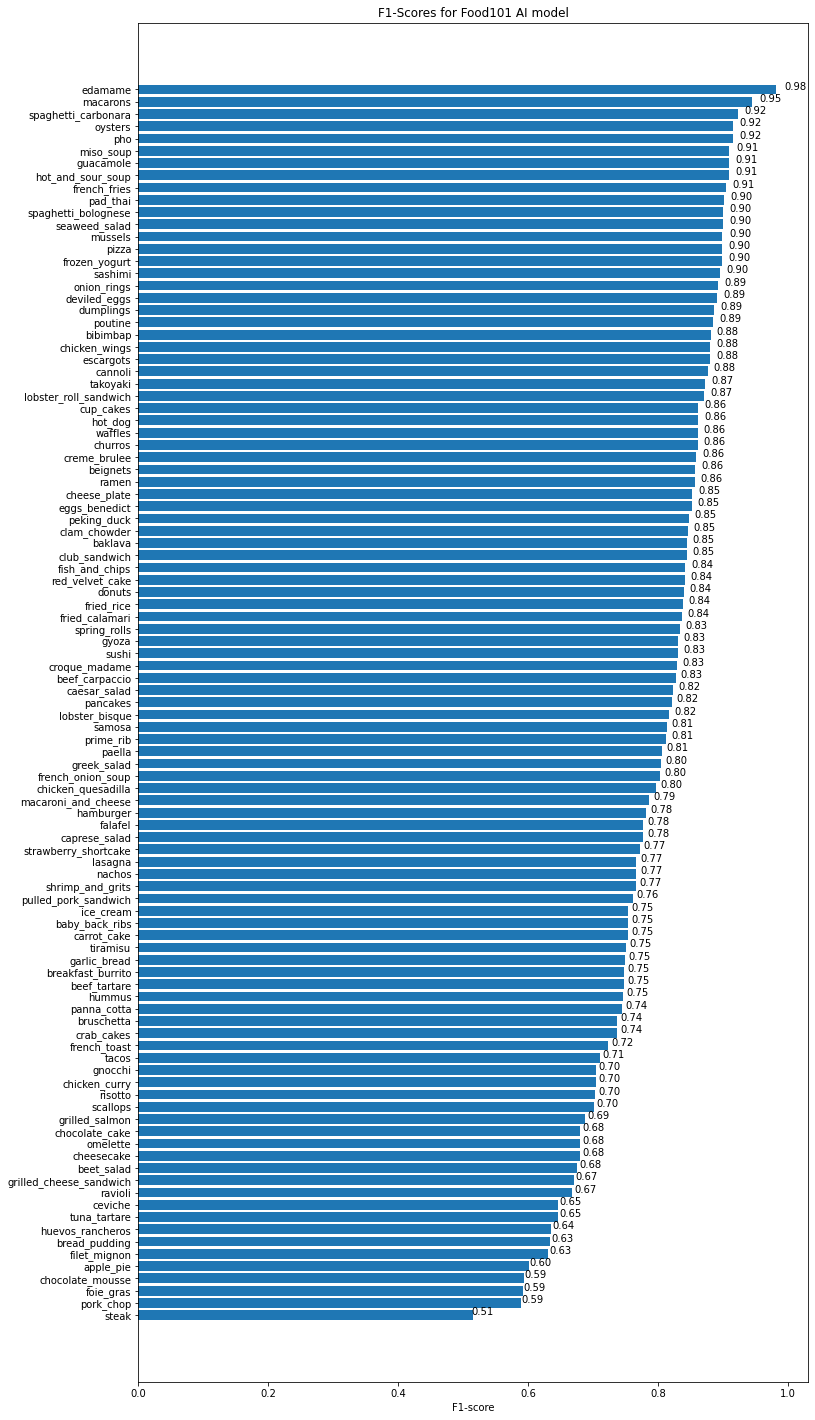

In [68]:
#Let's visualize it as a graph
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_values)), f1_values["f1-score"].values)
ax.set_yticks(range(len(f1_values)))
ax.set_xlabel("F1-score")
ax.set_yticklabels(f1_values["class_names"])
ax.set_title("F1-Scores for Food101 AI model")
ax.invert_yaxis()

#This part was taken from stackoverflow which is brilliant
def autolabel(x):
  for y in x:
    width = y.get_width()
    ax.text(1.03*width, y.get_y() + y.get_height()/1.5,
            f"{width:.2f}",
            ha="center", va="bottom")
autolabel(scores)